In [28]:
DFIRE_DATA_PATH = "D-Fire"
PLACES_DATA_PATH = "data_256"
FIRE_DATA_PATH = "fire_dataset"
FIRE_VIDEOS_DATA_PATH = "fire_videos.1406"

In [ ]:
from typing import Tuple, List
import torch
import torchvision.io
import os
#define type alias for tuple of (x,y) list of tensors for train and test


# image data which is an image tensor and a boolean (True if fire, False if no fire) for each image
ImageData = List[Tuple[torch.Tensor, bool]]
VideoData = List[torch.Tensor]



def get_video_data() -> Tuple[torch.Tensor, torch.Tensor]:
    """
    reads videos from directory and returns a tuple of tensors containing image data.
    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing two lists of tensors:
            - The first list contains tensors representing videos with fire.
            - The second list contains tensors representing videos without fire.
    """
    pos_videos = []

    for pos_video in os.listdir(os.path.join(FIRE_VIDEOS_DATA_PATH, "pos")):
        pos_video_path = os.path.join(FIRE_VIDEOS_DATA_PATH, "pos", pos_video)
        frames, _, _ = torchvision.io.read_video(pos_video_path)  # frames: [T, H, W, C]
        pos_videos.append(frames)  # Append the frames tensor to the list

    neg_videos = []
    for neg_video in os.listdir(os.path.join(FIRE_VIDEOS_DATA_PATH, "neg")):
        neg_video_path = os.path.join(FIRE_VIDEOS_DATA_PATH, "neg", neg_video)
        frames, _, _ = torchvision.io.read_video(neg_video_path)  # frames: [T, H, W, C]
        neg_videos.append(frames)  # Append the frames tensor to the list

    return pos_videos, neg_videos


fire_videos, nofire_videos = get_video_data()

/opt/homebrew/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torchvision/io/video.py:197: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([178, 256, 400, 3])


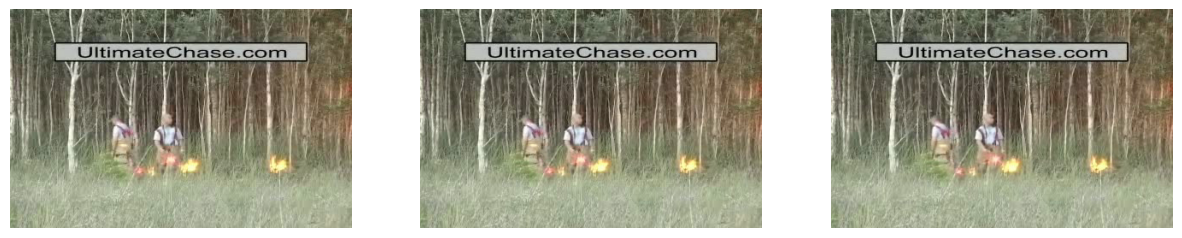

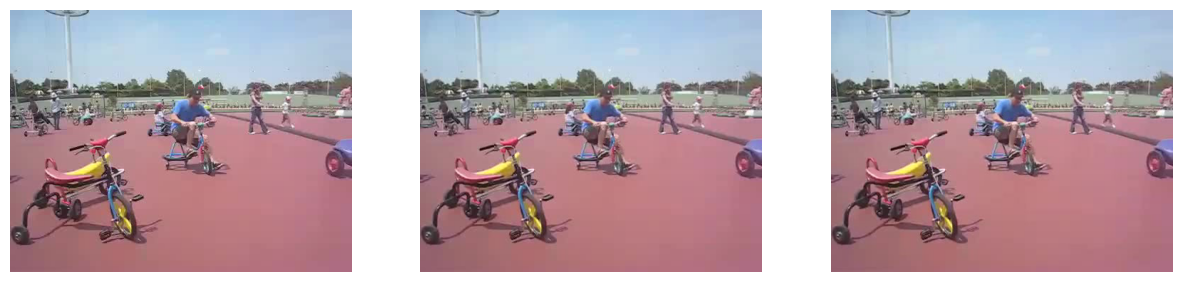

In [ ]:
print(fire_videos[0].shape)  # Print the shape of the first video tensor

# display first 5 frames of first video
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
def display_video(video_tensor: torch.Tensor, num_frames: int = 5):
    """
    Display the first num_frames of a video tensor
    each video tensor should be (T, H, W, C) shape
    Args:
        video_tensor (torch.Tensor): The video tensor to display.
        num_frames (int): The number of frames to display.
    

    """
    num_frames = min(num_frames, video_tensor.shape[0])
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i in range(num_frames):
        frame = video_tensor[i] #
        axes[i].imshow(frame)
        axes[i].axis('off')
    plt.show()
# Display the first 5 frames of the first video
display_video(fire_videos[0], num_frames=3)
# Display the first 5 frames of the first nofire video
display_video(nofire_videos[0], num_frames=3)


In [ ]:
FIRE_IMAGE_DATA_PATH = "Fire_Detection.v1i.coco/train/"
import random

def get_random_jpg_file_data(directory, n) -> List[torch.Tensor]:
    """
    Get n random jpg files from a directory and its subdirectories.
    Args:
        directory (str): The directory to search for jpg files.
        n (int): The number of random jpg files to return.
    Returns:
        List[torch.Tensor]: A list of n random jpg images converted to tensors.
    """
    jpg_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):
                jpg_files.append(os.path.join(root, file))
    
    # randomly sample n jpg file paths and then read the file as tensor
    image_tensors = list(map(lambda img_path : torchvision.io.read_image(img_path), 
                             random.sample(jpg_files, min(n, len(jpg_files)))))
    return image_tensors

def get_image_data(n_total_samples = 1000) -> Tuple[ImageData, ImageData, ImageData]:
    """
    Generate random data for training and testing.
    60/20/20 split for train/validation/test
    Args:
        n_total_samples (int): Total number of samples to generate.
    Returns:
        Tuple[ImageData, ImageData, ImageData]: Tuple of train, validation, and test data.
        Each data set is a list of tuples, where each tuple contains an image tensor and a boolean (True if fire, False if no fire).
    """


    # get complete dataset (random sample of n_total_samples images) such that 50% are fire and 50% are no fire
    num_fire_images = n_total_samples // 2
    num_nofire_images = num_fire_images
    fire_images =  list(zip(get_random_jpg_file_data(FIRE_IMAGE_DATA_PATH, num_fire_images), [True] * (num_fire_images)))
    nofire_images = list(zip(get_random_jpg_file_data(PLACES_DATA_PATH, num_nofire_images), [False] * (num_nofire_images)))

    # combine the lists and shuffle them
    all_images = fire_images + nofire_images
    random.shuffle(all_images)

    # split into train, val, test
    n_train_samples = int(n_total_samples * 0.6)
    n_val_samples = int(n_total_samples * 0.2)
    train_images = all_images[:n_train_samples]
    val_images = all_images[n_train_samples:n_train_samples + n_val_samples]
    test_images = all_images[n_train_samples + n_val_samples:] # will have remaining 20% of data since we are using 80% for train and val

    return train_images, val_images, test_images
    
    

train_images, val_images, test_images = get_image_data(1000)


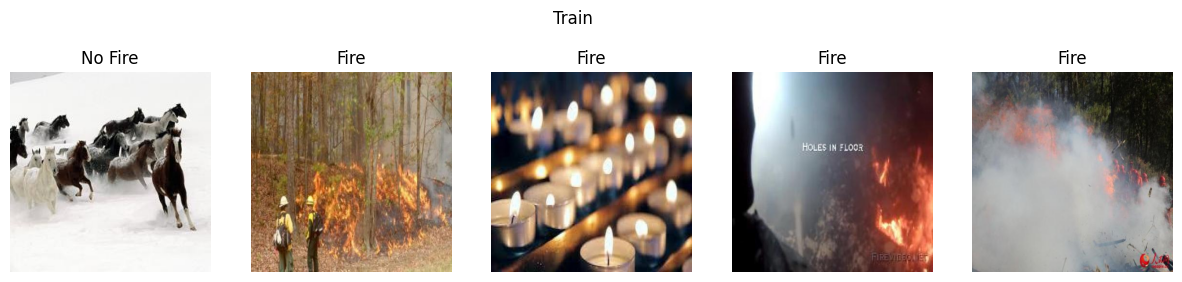

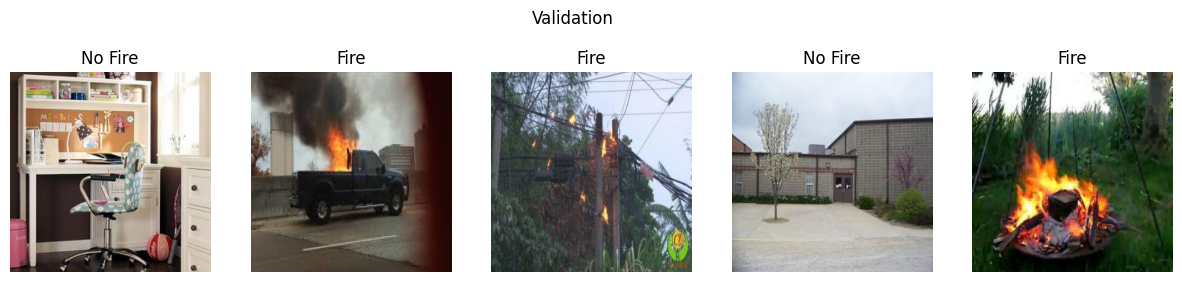

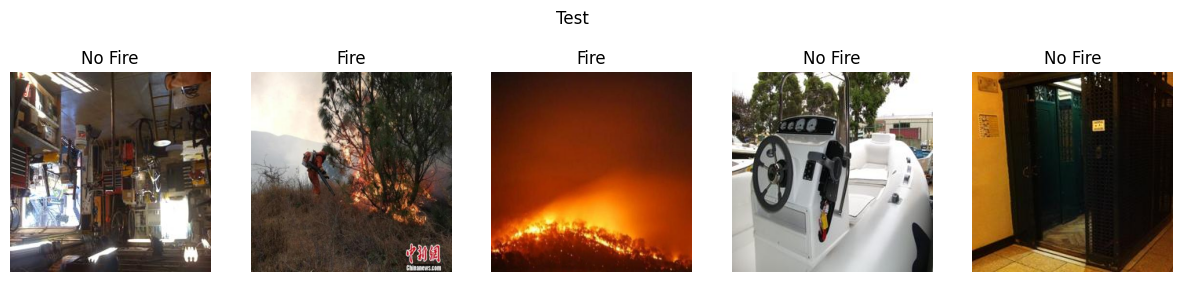

In [38]:

def display_images(image_data: ImageData, num_images: int = 5, title = "Random Sample of Images"):
    """
    Display random sample of a list of image tensors
    Args:
        image_data (ImageData): List of image tensors.
        num_images (int): Number of images to display.
        title (str): Title for the plot.
    
    """
    num_images = min(num_images, len(image_data))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # sample without replacement
    random_indices = random.sample(range(len(image_data)), num_images)

    # add title  to entire figure
    fig.suptitle(title)
    # remove white space between title and images
    fig.subplots_adjust(top=1.2)

    for i in range(num_images):
        img_tensor, is_fire = image_data[random_indices[i]]
        axes[i].imshow(F.to_pil_image(img_tensor))
        axes[i].set_title("Fire" if is_fire else "No Fire")
        axes[i].axis('off')
    plt.show()
# show random 5 training images
display_images(train_images, num_images=5, title = "Train")
# show random 5 validation images
display_images(val_images, num_images=5, title = "Validation")
# show random 5 test images
display_images(test_images, num_images=5 , title = "Test")